# Keypad Analyzer

결제 비밀번호 키패드를 분석하는 AI를 만들어 봅시다.

TMI: 곱켓팅을 위해 만들었으나 다른 네이버 페이 결제 상황에도 사용 가능합니다.

## 개발 환경
  * Windows10
  * Python 3.8~
    * opencv-python(cv2) 4.2~
    * tensorflow 2.3~
    * albumentations 0.4.6 ~

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import albumentations as A
import numpy as np
import cv2
import matplotlib.pyplot as plt

from datetime import datetime
import glob
import os

(585, 364, 3)


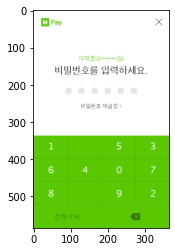

In [2]:
screenshot_array = cv2.imread("number_key_board.jpg")
print(screenshot_array.shape)
plt.imshow(screenshot_array)
plt.show()

# FHD 해상도에서는 가로*세로 365*585크기의 이미지가 캡쳐됩니다.
# 이 때 각 숫자를 32*32 pixel로 자르면 적당히 예쁘게 잘립니다. 
# 화면 해상도에 의한 에러를 막기위해 리사이즈 해 줍시다.
screenshot_array = cv2.resize(screenshot_array, (364, 585));

[0.1346153846153846, 0.38461538461538464, 0.6318681318681318, 0.8873626373626373]
[0.6256410256410256, 0.7350427350427351, 0.8427350427350427]
row_points:[366, 430, 493], col_points:[49, 140, 230, 323], crop size:32*32
shape: (32, 32, 3)


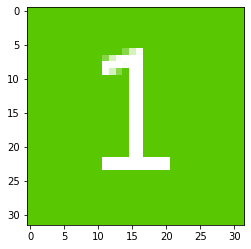

In [3]:
# 가로*세로 364*585 일 때 각 숫자의 중심부분의 행/렬은 다음과 같습니다. (그림판 확인 ㄱㄱ).
# rows: 366, 430, 493 
# columns: 49, 140, 230, 323

# 전체 이미지에서 각 숫자의 중심점을 구해봅시다.
col_ratio_points = [i/364 for i in (49,140,230,323)]
row_ratio_points = [i/585 for i in (366,430,493)]
print(col_ratio_points)
print(row_ratio_points)

row = [int(len(screenshot_array)*i) for i in row_ratio_points]  #0.579, 0.684, 0.789, 0.894
col = [int(len(screenshot_array[0])*i) for i in col_ratio_points] # (0, 0.25, 0.5, 0.75, 1)
crop_pxl = 16
print(f"row_points:{row}, col_points:{col}, crop size:{crop_pxl*2}*{crop_pxl*2}")


#각 행/렬 좌표를 딕셔너리 키로 만들고, 이미지를 value로 넣어줍시다.
keypad_img_dict = dict.fromkeys([(i,j) for i in range(1,4) for j in range(1,5)], None)
for i in range(1,4):
    for j in range(1,5):
        keypad_img_dict[(i,j)] = screenshot_array[row[i-1]-crop_pxl:row[i-1]+crop_pxl,
                                                  col[j-1]-crop_pxl:col[j-1]+crop_pxl]/255.0
print("shape:", keypad_img_dict[(1,1)].shape)

#1행 1렬의 요소 확인해보기
plt.imshow(keypad_img_dict[(1,1)])
plt.show()

## Deep Learning

딥러닝 모델을 준비해 봅시다.

tensorflow의 기본 tutorial인 mnist dataset을 이용한 모델을 사용해 한계를 체험해 보고 이를 극복해 봅시다.

### 1. tutorial model with mnist dataset

In [4]:
# loading dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# building model
tumorial_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

# training options
tumorial_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train
tumorial_model.fit(x_train, y_train, epochs=5)

# evaluate
test_loss, test_accuracy =  tumorial_model.evaluate(x_test,  y_test, verbose=2)
print(f"test loss: {test_loss:0.4f}")
print(f"test accuracy: {test_accuracy:0.4f}")
# model.save_weights('mnist_number_classifier.h5')

Epoch 1/5
1875/1875 [==============================] - 2s 923us/step - loss: 0.2944 - accuracy: 0.9138
Epoch 2/5
1875/1875 [==============================] - 2s 920us/step - loss: 0.1401 - accuracy: 0.9574
Epoch 3/5
1875/1875 [==============================] - 2s 925us/step - loss: 0.1082 - accuracy: 0.9673
Epoch 4/5
1875/1875 [==============================] - 2s 915us/step - loss: 0.0844 - accuracy: 0.9734
Epoch 5/5
1875/1875 [==============================] - 2s 924us/step - loss: 0.0750 - accuracy: 0.9763
313/313 - 0s - loss: 0.0758 - accuracy: 0.9763
test loss: 0.0758
test accuracy: 0.9763


test accuracy가 98% 가까이 나왔습니다.

이걸 그대로 사용해 보도록 하겠습니다.

우리의 이미지는 32*32*3(가로*세로*채널) 의 형태이지만

tutorial model은 28*28 의 흑백이미지를 입력으로 받습니다.

따라서 이미지의 크기와 채널수를 변환하여 인풋으로 넣어주도록 합시다.

(28, 28, 3)
(28, 28)


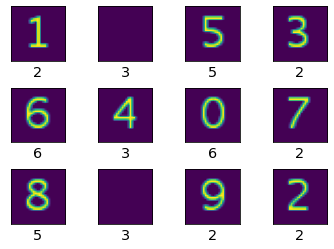

In [5]:
# tutorial model을 이용해 키패드 이미지 분석해보기
key_dict = dict.fromkeys(range(11),None)

# 인풋 변환 예시
img = keypad_img_dict[(1,1)].copy()
img = cv2.resize(img, (28,28)) # resize 
print(img.shape)
img = np.average(img, axis=2) # channels, dimension
print(img.shape)

# predict & visualization
fig = plt.figure()
plt.subplots_adjust(hspace=0.5)
for key,value in keypad_img_dict.items():
    #인풋값 변환
    img = cv2.resize(value, (28,28)).copy()
    img = np.average(img, axis=2)
    
    #딥러닝 모델로 예측
    pred = tumorial_model.predict(img[np.newaxis,:,:])[0].argmax()
    
    #인풋,예측값 서브플롯으로 그리기
    i = (key[0]-1)*4 + key[1]
    ax = fig.add_subplot(3,4,i)
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_xlabel(pred, fontsize='x-large') #예측값이 x 라벨로 나타납니다.
    ax.imshow(img) #원본그림

보시다 시피 예측 결과가 좋지 못합니다. 정확도가 10%가 안되네요.

테스트에선 98% 정확도였는데, 왜 이런 결과가 나왔을까요?

그 이유는 mnist데이터 셋으로 학습한 모델에 대해, 데이터셋 밖의 데이터를 예측 때문입니다.

mnist데이터셋은 매우 제한적인 데이터셋 입니다.

배경은 모두 검은색이고, 글씨는 모두 (8비트 기준) 255에 가까운 흰 색 입니다.

또 손글씨만 들어있는 데이터 셋 이므로, 컴퓨터가 폰트를 통해 생성한 숫자 이미지는 잘 예측하지 못 할 수 있습니다.

### 2. CNN model with custom dataset and augmentation

실사용이 가능한 모델을 개발 해 봅시다.

1. custom data 추가
2. augmentation 이용
3. CNN 모델 사용

이 세가지를 통해 목적을 달성해 보겠습니다.

#### 2.1 custom data

엑셀과 그림판을 이용해 33개의 글씨체 이미지를 만들어 보았습니다.

fhd해상도 모니터 기준

* 셀높이, 셀너비, 폰트크기 = 44, 12.4, 18 
* 각 숫자 가운데정렬. 배경 검게 칠함.
* ctrl+c로 카피 -> 그림판 붙여넣기 & 저장.

가로 세로 521*121 이미지를 얻을 수 있습니다.

(필자는 16:10 wqhd 해상도에서 셀높이, 셀너비, 폰트크기 = 30, 8.08, 14 로 521*121 얻음)

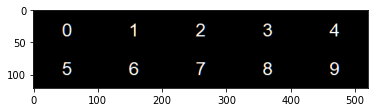

arial14_black&white.png


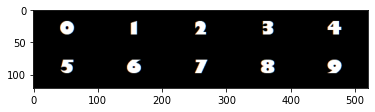

GilSansUB14_black&white.png


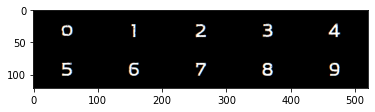

Mokgakpaim14_black&white.png


In [6]:
path_ = "C:\\Users\\lunat\\Desktop\\number dataset\\"
img_paths = glob.glob(path_+"*.png")

#0, 15, 30번 이미지만 확인해 봅시다.
for img_path in img_paths[::15]: 
    img = cv2.imread(img_path)
    plt.imshow(img)
    plt.show()
    print(img_path.split("\\")[-1])

현재 이미지는 흑(0,0,0) 과  백(255,255,255)으로만 되어있습니다.
다양한 명조 차이를 가지는 이미지들로 만들어 봅시다.
이후 숫자별로 오려서 저장하도록 하겠습니다.

In [7]:
# ### 다양한 크기, 명조차의 이미지 생성, 오려서 저장 ###

# img_paths = glob.glob(path_ + "*.png")
# print(img_paths)

# ### 폴더 생성 ###
# import os
# path_ = "C:\\Users\\lunat\\Desktop\\number dataset\\"
# for i in range(10):
#     os.mkdir(path_ + f"{i}")
# os.mkdir(path_ + "NaN")

# r_s = [19, 21, 24, 28] # 정사각 이미지 변의 길이의 절반. (반지름처럼;)
# for r_ in r_s: # 4
#     for img_path in img_paths: # * 32
#         print(f"working on {img_path}")
#         black_bg = cv2.imread(img_path) #black background불러옴
#         white_bg = cv2.bitwise_not(black_bg) #white background이미지 생성 (반전)
#         # black_bg, white_bg = black_bg/255. , white_bg/255. # 0~1.0 의 float으로 이미지 변환

#         black_bg_thinneds = [] #배경: 검은색 고정. 글자: 흰색 9단계
#         white_bg_thinneds = [] #배경: 흰색 9단계. 글자: 검은색 고정

#         for i in range(9):
#             black_bg_thinneds.append((black_bg / 8) * i)
#             white_bg_thinneds.append((white_bg / 8) * i)

#         font_name = img_path.split("\\")[-1].split("14")[0]
#         for index, bbt in enumerate(black_bg_thinneds): # * 9
#             for index_, wbt in enumerate(white_bg_thinneds): # * 9
#                 img = bbt+wbt
#                 for i in range(10): # * 10
#                     if i<5: wmp, hmp = 52 + (104*i), 30
#                     else: wmp, hmp = 52 + (104*(i-5)), 90
#                     cropped_img = img[hmp-r_:hmp+r_, wmp-r_:wmp+r_] # *255 # so that i can see in 탐색기.
#                     #path_ = "C:\\Users\\lunat\\Desktop\\number dataset\\"
#                     if index == index_:
#                         save_path = path_ + f"NaN\\{font_name}_{i}_b{index}w{index_}_{r_*2}x{r_*2}.jpg"
#                     else:
#                         save_path = path_ + f"{i}\\{font_name}_{i}_b{index}w{index_}_{r_*2}x{r_*2}.jpg"
#                     cv2.imwrite(save_path, cropped_img)

# # 4(cropsize) * 32(fonts) *9(bbg) *8(wbg) *10(0~10) = 4*32*72*10 =103,680 이미지 생성~!

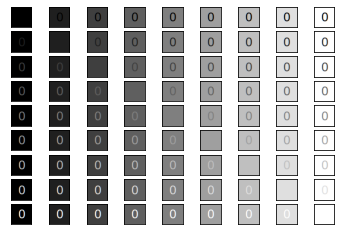

In [8]:
### 생성한 데이터셋 시각화 ###
img = cv2.imread(path_ + "arial14_black&white.png") #이미지가 있어야 합니다;
r_ = 24
wmp, hmp = 52 , 30
cropped_img = img[hmp-r_:hmp+r_, wmp-r_:wmp+r_]

black_bg= cropped_img
white_bg= white_bg = cv2.bitwise_not(black_bg)
black_bg, white_bg = black_bg/255. , white_bg/255. # 0~1.0 의 float으로 이미지 변환

black_bg_thinneds = [] #배경: 검은색 고정. 글자: 9단계
white_bg_thinneds = [] #배경: 흰색 9단계. 글자: 검은색 고정
mixed_72 = []
for i in range(9):
    black_bg_thinneds.append((black_bg / 8) * i)
    white_bg_thinneds.append((white_bg / 8) * i)

fig = plt.figure()
i = 1
for index, bbt in enumerate(black_bg_thinneds):
    for index_, wbt in enumerate(white_bg_thinneds):
        mixed_72.append(bbt+wbt)
        ax = fig.add_subplot(9, 9, i)
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(bbt+wbt)
        i+=1
plt.show()

손글씨도 인식할 수 있도록 mnist 트레이닝 데이터셋도 넣어줍시다.

`28*28`흑백 이미지이므로 `32*32*3`의 RGB 이미지로 변환하여 넣어주도록 합니다.

In [9]:
# ### mnist dataset중 training set을 생성한 dataset에 합치기 ###

# import tensorflow as tf
# import os

# mnist = tf.keras.datasets.mnist
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# for img, label, idx in zip(x_train, y_train, range(len(x_train))):
#     img = cv2.resize(img, (32,32))
#     RGBfied = np.stack((img,)*3, axis=2)
#     path_ = "C:\\Users\\lunat\\Desktop\\number dataset\\"
#     cv2.imwrite(path + f"{label}\\mnist_train_{idx:0>5}.jpg", RGBfied)

#### 2.2 augmentation & making generators for training

In [10]:
### building generator using keras.ImageDataGenerator and Albumentations ###

transform = A.Compose([
    ## color ##
    A.ChannelDropout(fill_value=0, p=0.1),
    A.ChannelDropout(fill_value=64, p=0.1),
    A.ChannelDropout(fill_value=128, p=0.15),
    A.ChannelDropout(fill_value=192, p=0.1),
    A.ChannelDropout(fill_value=255, p=0.1),
    A.InvertImg(p=0.15),

    ## resolution, noise ##
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=25, interpolation=0, border_mode=1, p=0.9),
    A.Downscale(scale_min=0.8, scale_max=0.95, p=0.2),
    A.Cutout(num_holes=5, max_h_size=2, max_w_size=2, fill_value=0, p=0.05),
    A.ElasticTransform(alpha=0.1, sigma=1, alpha_affine=1, interpolation=0, border_mode=1 ,p=0.25),
    A.Blur(blur_limit=(3,3), p=0.15),
    A.Cutout(num_holes=5, max_h_size=2, max_w_size=2, fill_value=0, p=0.1)

    ## Etc ##
    #A.Resize(28, 28, interpolation=1, p=1),
    #A.GridDistortion(p=0.1),
    #A.Equalize(p=1), -> 에러 낫던 것 같음;
    #A.JpegCompression(quality_lower=0, quality_upper=1, p=0.2), #float img에 사용 비추
    #A.RGBShift(p=1) # ->이거 넣으면 망함
    #A.MultiplicativeNoise(multiplier=[0.5, 1.5], p=1) #->이것도 넣으면 망함;
])

image_dir = "C:\\Users\\lunat\\Desktop\\number dataset"
resize_to = (32,32)
batch_size = 4096

idg = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split = 0.2
)

tdg = idg.flow_from_directory(
    directory=image_dir,
    classes=[str(i) for i in range(10)]+["NaN"],
    class_mode="categorical",
    target_size=resize_to,
    color_mode="rgb",
    subset="training",
    batch_size=batch_size,
    #interpolation='bicubic', #default is 'nearest'
    seed=1
)
vdg = idg.flow_from_directory(
    directory=image_dir,
    classes=[str(i) for i in range(10)]+["NaN"],
    class_mode="categorical",
    target_size=resize_to,
    color_mode="rgb",
    subset="validation",
    batch_size=batch_size,
    #interpolation='bicubic',
    seed=1
)

## keras 모델은 0~1.0으로 정규화 해주는게 좋음
## pyplot은 1이 넘어가는 float은 제대로 처리 못함. 0~255의 int이거나 0~1의 float인 상태로 plotting해야 함.

###### albumentations는 ######
# 1. 0~255 가 디폴트. -> 계산먼저 하고 모델에 넣기 전 255로 나눔. # (보니까 A.transform.Normalize있네;)
# 2. 흑백 이미지(채널 x or len(채널):1) 처리 잘 못하는 것 같음. 그냥 rgb로 가져와서 처리.

train_data_gen = ((np.array(list(transform(image=x)["image"]/255. for x in x_batch)),
                   np.array(list(y for y in y_batch))) for x_batch,y_batch in tdg)
valid_data_gen = ((np.array(list(transform(image=x)["image"]/255. for x in x_batch)),
                   np.array(list(y for y in y_batch))) for x_batch,y_batch in vdg)

#transform(image=x.squeeze(axis=2)

Found 133539 images belonging to 11 classes.
Found 33381 images belonging to 11 classes.


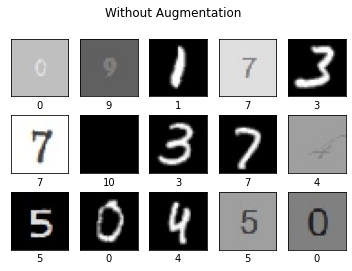

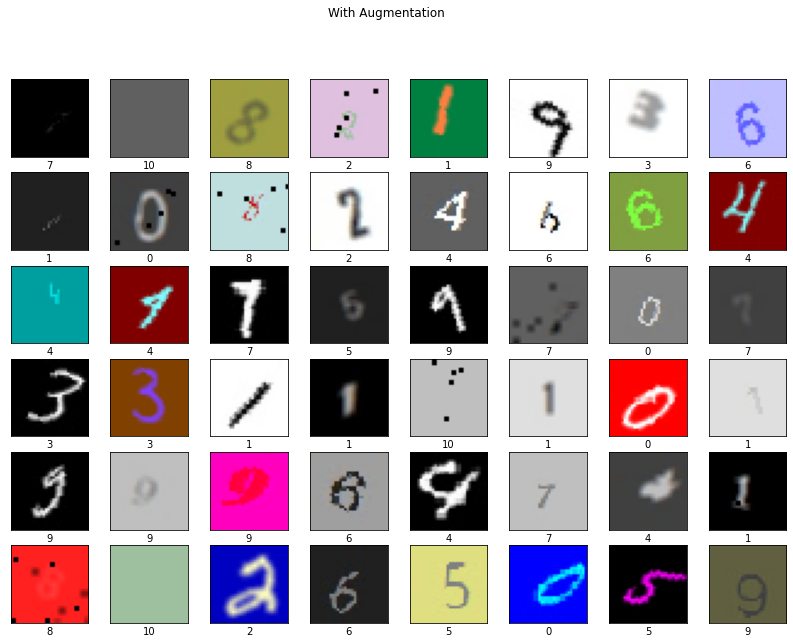

In [11]:
#### augmentation 안한 이미지 확인해보기 ####
x_batch,y_batch = next(tdg)

fig = plt.figure()
fig.suptitle('Without Augmentation')
i = 1
x_batch, y_batch = next(tdg)
x_batch, y_batch = x_batch/255., y_batch/255. 
for x, y in zip(x_batch[:15], y_batch[:15]):
    # print(x.shape, y.argmax())
    ax = fig.add_subplot(3,5,i)
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_xlabel(y.argmax())
    ax.imshow(x)
    i += 1
    
#### augmentation 한 이미지 확인해보기 ####
x_batch, y_batch = next(train_data_gen) 
fig = plt.figure(figsize=(14,10))
fig.suptitle('With Augmentation')
i = 1
for x, y in zip(x_batch[:48], y_batch[:48]):
    # print(x.shape, y.argmax())
    ax = fig.add_subplot(6,8,i)
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_xlabel(y.argmax())
    ax.imshow(x)
    i += 1

#### 2.3 Building CNN model, train and test

일단, 머신러닝 리서처가 아닌 초보 개발자 입니다.

모델에 개선할 부분이 많겠지만 일단 넘어갑시다 ㅎㅎ

In [12]:
### configuration ###

now = datetime.now().strftime("%Y.%m.%d.%H.%M")
version = "v0.3"
save_to = "C:\\Users\\lunat\\Desktop\\weights\\number_classifier_"+version+"_"+now+".h5"
print(f"save_to: {save_to}")


### building model ###
model = tf.keras.models.Sequential([
    #tf.keras.Input(shape=(32, 32, 3), batch_size=batch_size),
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(11, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### callbacks ###
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=save_to, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch', options=None,
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=25, verbose=1, mode='auto',
    baseline=None, restore_best_weights=False
)

### training model ###
history = model.fit(x = train_data_gen,
          validation_data = valid_data_gen,
          steps_per_epoch = 30,
          validation_steps = 10,
          callbacks=[checkpoint, early_stop],
          epochs=200)

print("finished training")

save_to: C:\Users\lunat\Desktop\weights\number_classifier_v0.3_2020.10.22.01.54.h5
Epoch 1/200
30/30 [==============================] - ETA: 0s - loss: 2.1567 - accuracy: 0.2359
Epoch 00001: val_loss improved from inf to 2.26588, saving model to C:\Users\lunat\Desktop\weights\number_classifier_v0.3_2020.10.22.01.54.h5
30/30 [==============================] - 65s 2s/step - loss: 2.1567 - accuracy: 0.2359 - val_loss: 2.2659 - val_accuracy: 0.2036
Epoch 2/200
30/30 [==============================] - ETA: 0s - loss: 1.6544 - accuracy: 0.4452
Epoch 00002: val_loss improved from 2.26588 to 2.03692, saving model to C:\Users\lunat\Desktop\weights\number_classifier_v0.3_2020.10.22.01.54.h5
30/30 [==============================] - 66s 2s/step - loss: 1.6544 - accuracy: 0.4452 - val_loss: 2.0369 - val_accuracy: 0.2972
Epoch 3/200
30/30 [==============================] - ETA: 0s - loss: 1.3410 - accuracy: 0.5552
Epoch 00003: val_loss improved from 2.03692 to 1.74791, saving model to C:\Users\lunat

Epoch 24/200
30/30 [==============================] - ETA: 0s - loss: 0.3910 - accuracy: 0.8782
Epoch 00024: val_loss did not improve from 0.72507
30/30 [==============================] - 65s 2s/step - loss: 0.3910 - accuracy: 0.8782 - val_loss: 0.7345 - val_accuracy: 0.7676
Epoch 25/200
30/30 [==============================] - ETA: 0s - loss: 0.3844 - accuracy: 0.8810
Epoch 00025: val_loss improved from 0.72507 to 0.71076, saving model to C:\Users\lunat\Desktop\weights\number_classifier_v0.3_2020.10.22.01.54.h5
30/30 [==============================] - 64s 2s/step - loss: 0.3844 - accuracy: 0.8810 - val_loss: 0.7108 - val_accuracy: 0.7737
Epoch 26/200
30/30 [==============================] - ETA: 0s - loss: 0.3744 - accuracy: 0.8831
Epoch 00026: val_loss did not improve from 0.71076
30/30 [==============================] - 65s 2s/step - loss: 0.3744 - accuracy: 0.8831 - val_loss: 0.7408 - val_accuracy: 0.7693
Epoch 27/200
30/30 [==============================] - ETA: 0s - loss: 0.3678 

Epoch 50/200
30/30 [==============================] - ETA: 0s - loss: 0.2613 - accuracy: 0.9206
Epoch 00050: val_loss improved from 0.58819 to 0.58438, saving model to C:\Users\lunat\Desktop\weights\number_classifier_v0.3_2020.10.22.01.54.h5
30/30 [==============================] - 63s 2s/step - loss: 0.2613 - accuracy: 0.9206 - val_loss: 0.5844 - val_accuracy: 0.8180
Epoch 51/200
30/30 [==============================] - ETA: 0s - loss: 0.2537 - accuracy: 0.9238
Epoch 00051: val_loss improved from 0.58438 to 0.57532, saving model to C:\Users\lunat\Desktop\weights\number_classifier_v0.3_2020.10.22.01.54.h5
30/30 [==============================] - 65s 2s/step - loss: 0.2537 - accuracy: 0.9238 - val_loss: 0.5753 - val_accuracy: 0.8245
Epoch 52/200
30/30 [==============================] - ETA: 0s - loss: 0.2518 - accuracy: 0.9237
Epoch 00052: val_loss did not improve from 0.57532
30/30 [==============================] - 64s 2s/step - loss: 0.2518 - accuracy: 0.9237 - val_loss: 0.5838 - val

Epoch 77/200
30/30 [==============================] - ETA: 0s - loss: 0.1928 - accuracy: 0.9419
Epoch 00077: val_loss did not improve from 0.52552
30/30 [==============================] - 64s 2s/step - loss: 0.1928 - accuracy: 0.9419 - val_loss: 0.5294 - val_accuracy: 0.8412
Epoch 78/200
30/30 [==============================] - ETA: 0s - loss: 0.1906 - accuracy: 0.9425
Epoch 00078: val_loss improved from 0.52552 to 0.52294, saving model to C:\Users\lunat\Desktop\weights\number_classifier_v0.3_2020.10.22.01.54.h5
30/30 [==============================] - 65s 2s/step - loss: 0.1906 - accuracy: 0.9425 - val_loss: 0.5229 - val_accuracy: 0.8435
Epoch 79/200
30/30 [==============================] - ETA: 0s - loss: 0.1928 - accuracy: 0.9422
Epoch 00079: val_loss improved from 0.52294 to 0.52042, saving model to C:\Users\lunat\Desktop\weights\number_classifier_v0.3_2020.10.22.01.54.h5
30/30 [==============================] - 66s 2s/step - loss: 0.1928 - accuracy: 0.9422 - val_loss: 0.5204 - val

Epoch 133/200
30/30 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.9567
Epoch 00133: val_loss did not improve from 0.46814
30/30 [==============================] - 65s 2s/step - loss: 0.1458 - accuracy: 0.9567 - val_loss: 0.5010 - val_accuracy: 0.8562
Epoch 134/200
30/30 [==============================] - ETA: 0s - loss: 0.1436 - accuracy: 0.9574
Epoch 00134: val_loss did not improve from 0.46814
30/30 [==============================] - 66s 2s/step - loss: 0.1436 - accuracy: 0.9574 - val_loss: 0.4795 - val_accuracy: 0.8599
Epoch 135/200
30/30 [==============================] - ETA: 0s - loss: 0.1463 - accuracy: 0.9562
Epoch 00135: val_loss did not improve from 0.46814
30/30 [==============================] - 63s 2s/step - loss: 0.1463 - accuracy: 0.9562 - val_loss: 0.4710 - val_accuracy: 0.8599
Epoch 136/200
30/30 [==============================] - ETA: 0s - loss: 0.1446 - accuracy: 0.9565
Epoch 00136: val_loss did not improve from 0.46814
30/30 [==============

30/30 [==============================] - ETA: 0s - loss: 0.1196 - accuracy: 0.9645
Epoch 00189: val_loss did not improve from 0.43407
30/30 [==============================] - 64s 2s/step - loss: 0.1196 - accuracy: 0.9645 - val_loss: 0.4464 - val_accuracy: 0.8698
Epoch 190/200
30/30 [==============================] - ETA: 0s - loss: 0.1192 - accuracy: 0.9641
Epoch 00190: val_loss did not improve from 0.43407
30/30 [==============================] - 65s 2s/step - loss: 0.1192 - accuracy: 0.9641 - val_loss: 0.4570 - val_accuracy: 0.8670
Epoch 191/200
30/30 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9654
Epoch 00191: val_loss did not improve from 0.43407
30/30 [==============================] - 65s 2s/step - loss: 0.1162 - accuracy: 0.9654 - val_loss: 0.4439 - val_accuracy: 0.8748
Epoch 192/200
30/30 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.9642
Epoch 00192: val_loss did not improve from 0.43407
30/30 [============================

학습이 완료 된 모델을 불러와 mnist test데이터셋으로 평가해 보도록 합시다.

52
top 1 accuracy:99.49%
top 2 accuracy:99.91%


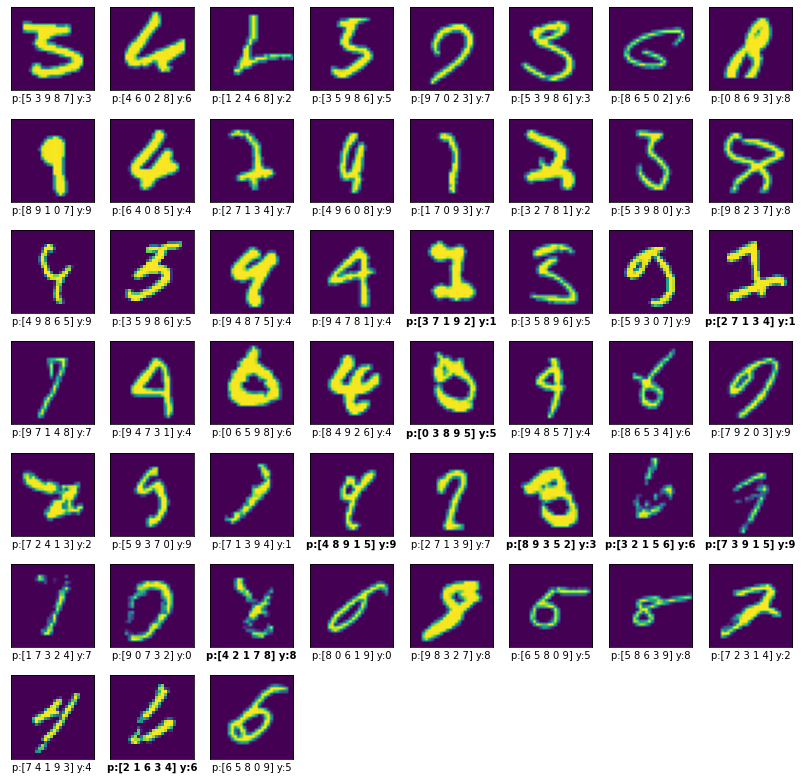

In [14]:
# saved_model_path ="C:\\Users\\lunat\\Desktop\\weights\\number_classifier_v0.2_thic_2020.10.21.h5"
saved_model_path = save_to

### (28*28)이미지를 (32*32*3)으로 변환 ###
RGB_x_test = []
for i in x_test[:,:,:]:
    #print(i[:,:,np.newaxis].shape)
    i = cv2.resize(i, (32,32))
    RGBfied = np.stack((i,)*3, axis=2)
    #print(RGBfied.shape)
    RGB_x_test.append(RGBfied)
RGB_x_test = np.array(RGB_x_test)

### 모델 불러오기 & 예측 ###
loaded_model = tf.keras.models.load_model(saved_model_path)
pred = loaded_model.predict(RGB_x_test)
cnt, correct, correct_second = 0, 0, 0

fig = plt.figure(figsize=(14,14))
i = 0
for x,p,y in zip(x_test, pred, y_test):
    cnt += 1
    if p.argmax() == y:
        correct += 1        
    ## top1으로 맞추지 못 한 케이스들 시각화 ##
    elif p.argsort()[-2] == y:
        i += 1
        correct_second += 1
        ax = fig.add_subplot(7,8,i)
        ax.set_xticks([]), ax.set_yticks([])
        ax.set_xlabel(f"p:{p.argsort()[:5:-1]} y:{y}")
        ax.imshow(x)
    else: #bold로 표시
        i += 1
        ax = fig.add_subplot(7,8,i)
        ax.set_xticks([]), ax.set_yticks([])
        ax.set_xlabel(f"p:{p.argsort()[:5:-1]} y:{y}", fontweight='bold') 
        ax.imshow(x)
        
print(i)
print(f"top 1 accuracy:{correct*100/cnt:0.2f}%") #->99.48%
print(f"top 2 accuracy:{(correct+correct_second)*100/cnt:0.2f}%") #->99.92%

사람이 봐도 혼동할 만한 이미지에 대해서 잘못 판단한 정도로 보여집니다.

top5 이내로는 모두 예측에 성공하였고, 대부분 top1, top2에서 예측에 성공했네요.

물론 사람이면 더 잘 맞췄을 것으로 생각됩니다. 

네이버 쇼핑 키패드에 대해서 예측해 보도록 하겠습니다.

{0: (2, 3), 1: (1, 1), 2: (3, 4), 3: (1, 4), 4: (2, 2), 5: (1, 3), 6: (2, 1), 7: (2, 4), 8: (3, 1), 9: (3, 3), 10: (3, 2)}


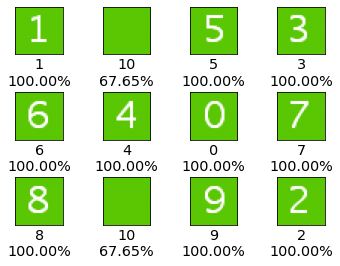

In [15]:
### 네이버 쇼핑 predict 해보기 ###

fig = plt.figure()
plt.subplots_adjust(hspace=0.8)
key_dict = dict.fromkeys(range(11),None)

for key,value in keypad_img_dict.items():
    img = value.copy()
    pred = loaded_model.predict(img[np.newaxis,:,:,:])[0]
    #print(f"keypad_img_dict[{key}]: predicted as {pred: >2}")
    key_dict[pred.argmax()] = key
    
    # 인풋,예측값 서브플롯으로 그리기
    i = (key[0]-1)*4 + key[1]
    ax = fig.add_subplot(3,4,i)
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_xlabel(f"{pred.argmax()}\n{pred.max()*100:0.2f}%", fontsize='x-large')
    ax.imshow(img)

print(key_dict)

굿! :]